## Split Margin

Below we investigate the Split Margin feature, and see how it may be incorporated into a predicative model.

----

### 0. Read cleansed data

In [2]:
import os
import decouple
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as plticker

from scipy.stats import zscore

config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
sys.path.insert(0, '')

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')
df_raw['RaceDate'] = pd.to_datetime(df_raw['RaceDate'], format='%Y-%m-%d')

display(df_raw.head())

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate,FieldSize
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6


### 1. Split Margin Place & Box vs. Win Rate

We can see from the plot below that box 8 benefits the most with having the fastest acceleration - A 63.44% win rate if places first at the split marker. I'm speculating that this is because if box 8 has the fastest acceleration, then it has a greater chance of cutting across and reaching the rail early. Whereas box 5 benefits the least, with a 58.12% win rate if it places first at the split marker. Neverthless, irrespective of the box, if a greyhound leads at the split marker it has a very high probability of winning the race.

,Box,SplitMarginPlace,NumberOfWins,SampleSize,WinRate
0,1,1,12374,20359,60.78
8,2,1,9406,15392,61.11
16,3,1,7048,11771,59.88
24,4,1,8093,13397,60.41
32,5,1,6397,11002,58.14
40,6,1,5959,9822,60.67
48,7,1,6646,11320,58.71
56,8,1,6996,11045,63.34


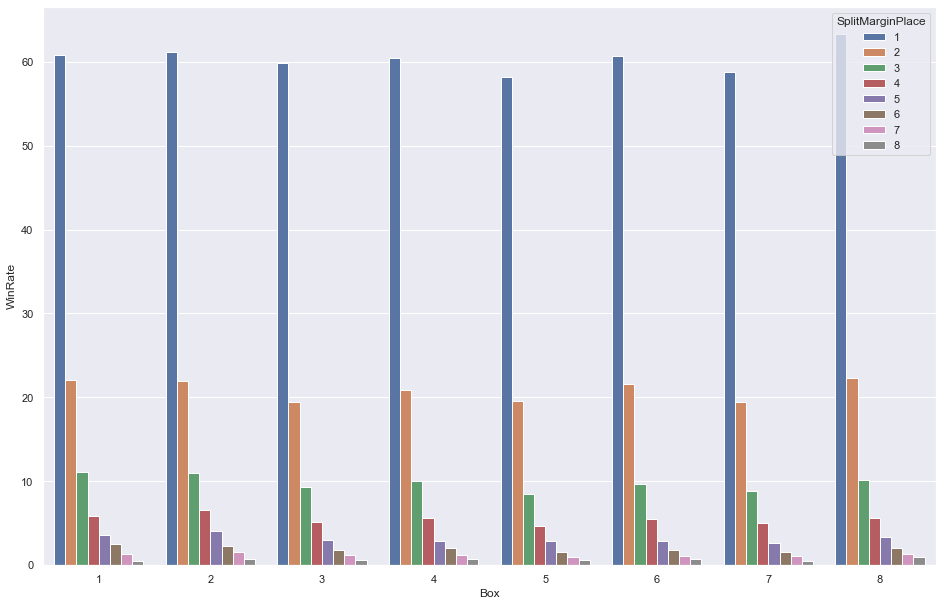

In [3]:
# Copy
df = df_raw.copy()

# Drop NaN SplitMargin's
df = df[~df['SplitMargin'].isna()]

# Remove incorrect SplitMargins
df = df[df.SplitMargin >= 2.2]

# Create SplitMarginPlace column (who arrived first, second, etc at marker)
df = df.sort_values(by=['FasttrackRaceId', 'SplitMargin'], ascending=True)
df['SplitMarginPlace'] = df.groupby('FasttrackRaceId')['SplitMargin'].cumcount()+1

# Create win column
df['Win'] = (df['Place'] == 1).astype(int)

# Groupby Box and SplitMarginPlace and determine win rates
df = df.groupby(['Box', 'SplitMarginPlace'], as_index=False).agg(NumberOfWins=('Win', 'sum'),
                                                                SampleSize=('Win', 'count'))
df['WinRate'] = round(100*df['NumberOfWins']/df['SampleSize'], 2)

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(16, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
sns.barplot(data=df, x="Box", y="WinRate", hue="SplitMarginPlace")

display(df[df.SplitMarginPlace == 1])

Let's now look at this again, but instead of place we will look at quantiles built upon the relative splitmargin performance for each greyhound in a race.

From the graph below, if a Box 1 greyhound has a significantly higher average SplitMargin than their competitors in the last 5 races, they have a very good chance of winning the race - Quantile 7 has a 30.7% probability of winning, and Quantile 6 has a 26.23% chance of winning.

It's interesting to note that for all other boxes (boxes 2 to 8), if the greyhound falls into Quantile 7 (significantly faster than all other greyhounds in the race) it has the same Win Rate as a greyhound in Box 1 in Quantile 6.

C:\Users\CharlesBray\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,Box,SplitMarginQuantile,NumberOfWins,SampleSize,WinRate
0,1,0.0,670,6446,10.39
1,1,1.0,786,6548,12.00
2,1,2.0,1038,6543,15.86
3,1,3.0,1123,6429,17.47
4,1,4.0,1215,6501,18.69
...,...,...,...,...,...
59,8,3.0,697,6354,10.97
60,8,4.0,849,6437,13.19
61,8,5.0,1078,6463,16.68
62,8,6.0,1235,6282,19.66


<AxesSubplot:xlabel='Box', ylabel='WinRate'>

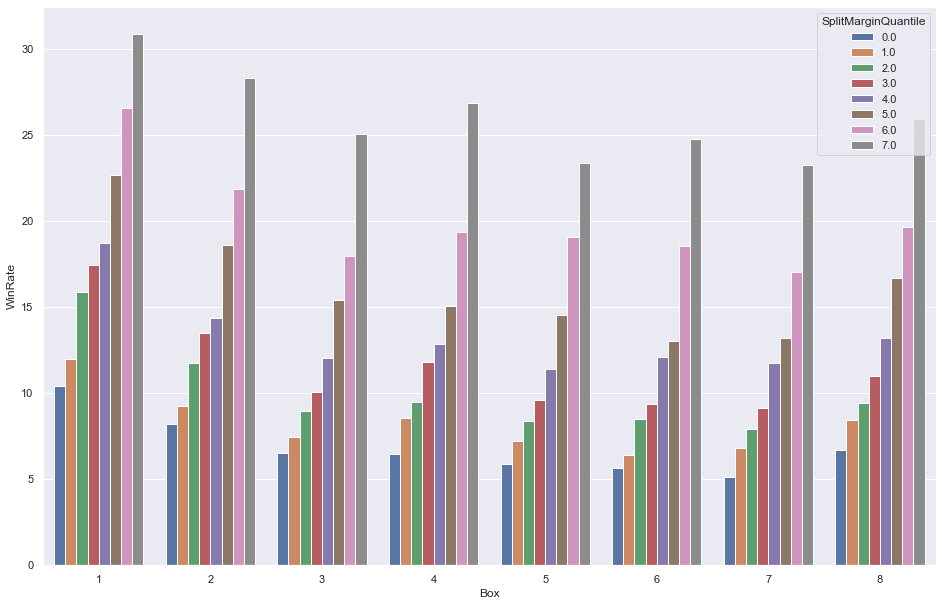

In [5]:
# Copy
df = df_raw.copy()

# Drop NaN SplitMargin's
df = df[~df['SplitMargin'].isna()]

# Remove incorrect SplitMargins
df = df[df.SplitMargin >= 2.2]

# Invert Split Margin (such that smaller value is slower, and larger value is faster)
df['SplitMargin'] = 1/df['SplitMargin']

# Create a normalised split margin for each dog based on the Track and Dist
df['SplitMarginNorm'] = df.groupby('TrackDist')['SplitMargin'].transform(lambda x: zscore(x))

# MA over past 5 races and shift
df["SplitMargin_MA_5"] = df.groupby("FasttrackDogId")["SplitMarginNorm"].transform(lambda x: x.rolling(5).mean().shift(1))

# Z-score each greyhounds moving average based on other greyhounds in each race
df['SplitMargin_MA_5_Z'] = df.groupby("FasttrackRaceId")["SplitMargin_MA_5"].transform(lambda x: zscore(x))

# Seperate these z-score values into 8 quantiles (for easier visualisation)
df['SplitMarginQuantile'] = pd.qcut(df['SplitMargin_MA_5_Z'], 8, labels=False)

# Create win column
df['Win'] = (df['Place'] == 1).astype(int)

# Remove NaN
df = df[~df.SplitMarginQuantile.isna()]

# Groupby Box and SplitMarginPlace and determine win rates
df = df.groupby(['Box', 'SplitMarginQuantile'], as_index=False).agg(NumberOfWins=('Win', 'sum'),
                                                                SampleSize=('Win', 'count'))
df['WinRate'] = round(100*df['NumberOfWins']/df['SampleSize'], 2)

display(df)

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(16, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
sns.barplot(data=df, x="Box", y="WinRate", hue="SplitMarginQuantile")

### 2. First to Split Marker Importance by Track, Distance

Below, we look at the importance of reaching the split marker first by studying the win rate for the greyhounds that do reach the split marker first by (track, distance). We can see that reaching the importance is quite variable by (track, distance) and should be incorporated into our model.

<AxesSubplot:xlabel='TrackDist', ylabel='WinRate'>

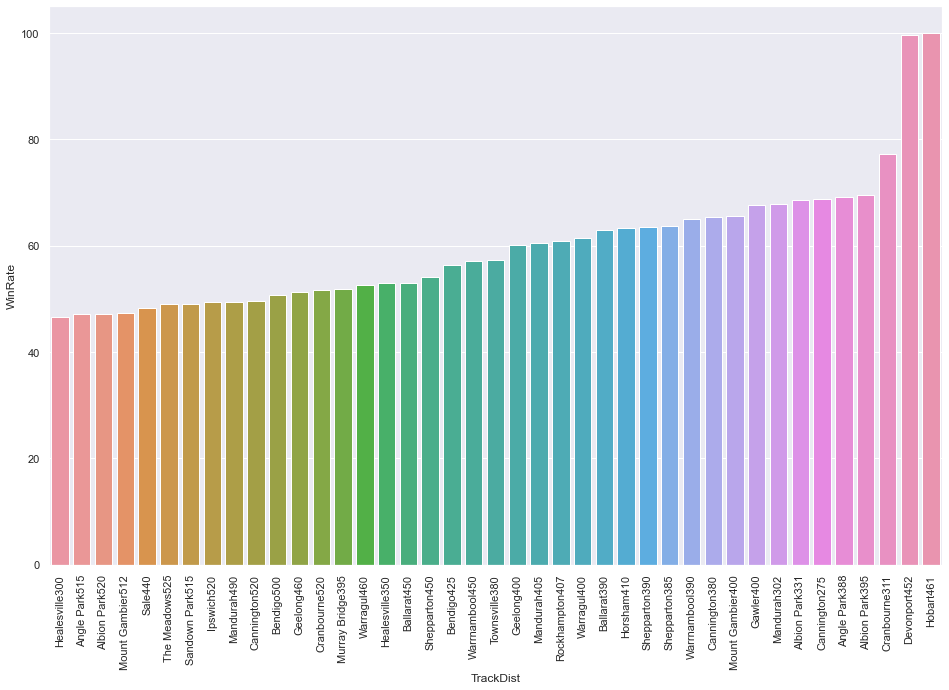

In [8]:
# Copy raw dataframe
df = df_raw.copy()

# Remove NaN SplitMargin's for now
df = df[~df['SplitMargin'].isna()]

# Remove outlier values
upper_limit = df.SplitMargin.median() + 3*df.SplitMargin.mad()
lower_limit = df.SplitMargin.median() - 3*df.SplitMargin.mad()
df = df[df['SplitMargin'].between(lower_limit, upper_limit)]

# Create a SplitMarkerPlace column
df = df.sort_values(by=['FasttrackRaceId', 'SplitMargin'], ascending=True)
df['SplitMarginPlace'] = df.groupby('FasttrackRaceId').cumcount()+1

# Create a SplitMarginWin column (who reach the split marker first)
df['SplitMarginWin'] = (df['SplitMarginPlace'] == 1).astype(int)

# Take only Greyhounds who reached split marker first, and calculate the win rate by track and distance
df = df[df['SplitMarginWin'] == 1]
df['Win'] = (df['Place'] == 1).astype(int)
df = df.groupby('TrackDist', as_index=False).agg(NumberOfWins = ('Win', 'sum'),
                                                 SampleSize = ('Win', 'count'))
df['WinRate'] = round(100*df['NumberOfWins']/df['SampleSize'], 2)

# Take only TrackDist with at least a sample size of 1000
df = df[df['SampleSize'] >= 1000]
df = df.sort_values(by='WinRate') 

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(16, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
plt.xticks(rotation=90)
sns.barplot(data=df, x="TrackDist", y="WinRate")